### Overview

In this project, I will create a neural network that classifies land uses and land covers from satellite imagery. I will save the model using TensorFlow callbacks and reload later. I will also load in a pre-trained neural network classifier and compare performance with it.

### Getting started!

We'll start running some imports and loading the dataset. Do not edit the existing imports in the following cell.

## Credits
Some of the material in this notebook has been taken from a Coursera Deep Learning course

In [ ]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

In [ ]:

#This cell REQUIRED if running on Colab
#Comment this cell if NOT running on Colab

# Download the dataset (data.zip) containing training and test images
!gdown --id 1wCT5kTQfViAzD9yr27L172oMjEIX0rxV

#Download the overview image (eurosat_overview_small.jpeg)
!gdown --id 19j5hPsSKVbHU1ptW_Ro11jycd-rkPEvf


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wCT5kTQfViAzD9yr27L172oMjEIX0rxV
To: /content/data.zip
100% 60.7M/60.7M [00:02<00:00, 29.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19j5hPsSKVbHU1ptW_Ro11jycd-rkPEvf
To: /content/eurosat_overview_small.jpeg
100% 187k/187k [00:00<00:00, 92.1MB/s]


In [ ]:
# Unzip the dataset
data_dir = "data.zip"

#unzip the dataset if not already done
if not os.path.exists("data"):
  !unzip "$data_dir"

Archive:  data.zip
   creating: data/
  inflating: data/y_train.npy        
  inflating: data/x_test.npy         
  inflating: data/x_train.npy        
  inflating: data/y_test.npy         


#### The EuroSAT dataset

I will use the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake.


---
![Overview of Eurosat dataset](https://drive.google.com/uc?id=19j5hPsSKVbHU1ptW_Ro11jycd-rkPEvf)
![Overview of Eurosat dataset](eurosat_overview_small.jpeg)

For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

My goal is to construct a neural network that classifies a satellite image into one of these 10 classes, as well as applying some  saving and loading techniques. In addition, I will apply transfer learning to perform classification on this dataset.

#### Import the data

The dataset I will train my model on is a subset of the total data, with 4000 training images and 1000 testing images, with roughly equal numbers of each class.
The train and test datasets required for this project are stored in the `data` folder.

The datasets will be loaded below into variables `x_train`, `y_train`, `x_test`, `y_test`.

In [ ]:
# Import the Eurosat data from local folder. Assuming it is placed in a data folder relative to this notebook.

def load_eurosat_data():
    x_train = np.load('data/x_train.npy')
    y_train = np.load('data/y_train.npy')
    x_test  = np.load('data/x_test.npy')
    y_test  = np.load('data/y_test.npy')
    return (x_train, y_train), (x_test, y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = load_eurosat_data()

#Pre-process images
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
print("{} training data examples".format(x_train.shape[0]))
print("{} test data examples".format(x_test.shape[0]))

print("Shape of first training image: {}".format(x_train[0].shape))
print("Training label of first training image: {}".format(y_train[0]))
print(y_train.min(), y_train.max())

4000 training data examples
1000 test data examples
Shape of first training image: (64, 64, 3)
Training label of first training image: [2]
0 9


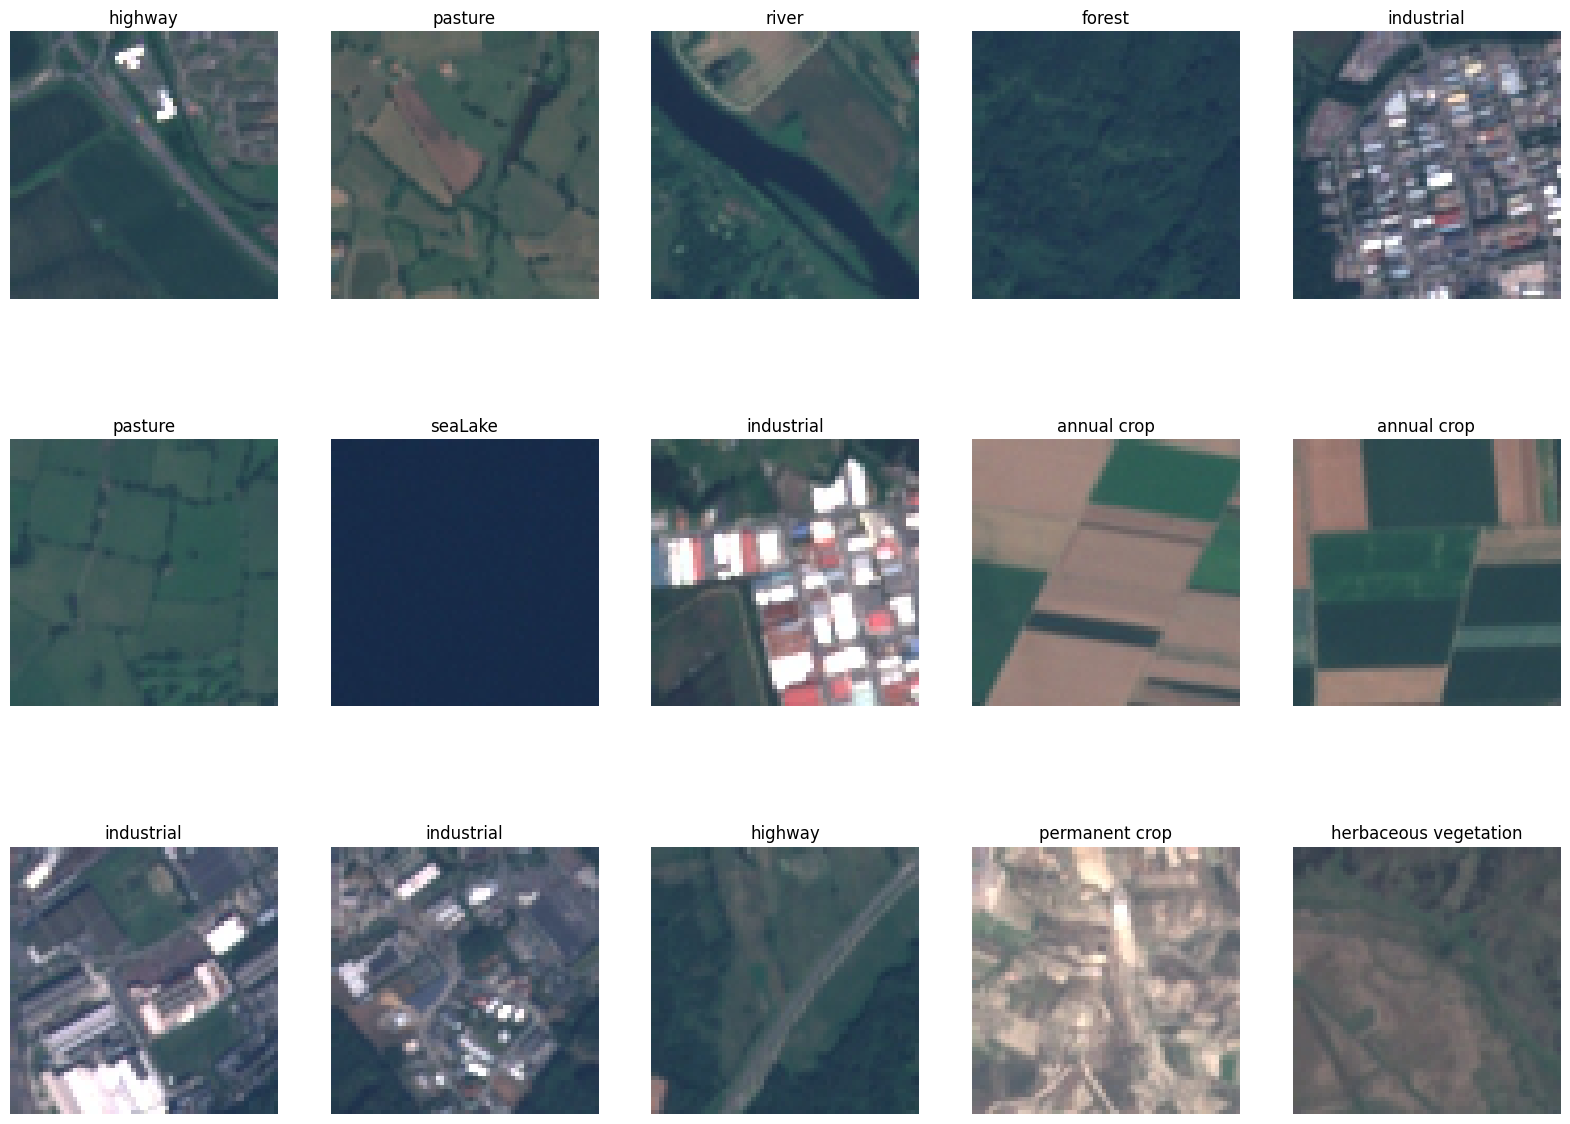

In [ ]:
# Display a few images and labels
#Run this cell multiple times to get flavor of the kind of images in this dataset

class_names = ['annual crop', 'forest', 'herbaceous vegetation', 'highway',  'industrial',   'pasture',
                         'permanent crop', 'residential', 'river', 'seaLake']

plt.figure(figsize=(20,15))
inx = np.random.choice(x_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')

In [ ]:
for i in range(10):
    print(f"Number of images with class label {class_names[i]} = {np.sum(y_train == i)}")

Number of images with class label annual crop = 406
Number of images with class label forest = 400
Number of images with class label herbaceous vegetation = 394
Number of images with class label highway = 410
Number of images with class label industrial = 397
Number of images with class label pasture = 419
Number of images with class label permanent crop = 411
Number of images with class label residential = 398
Number of images with class label river = 397
Number of images with class label seaLake = 368


In [ ]:
# same as above but in one line
# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

array([[  0, 406],
       [  1, 400],
       [  2, 394],
       [  3, 410],
       [  4, 397],
       [  5, 419],
       [  6, 411],
       [  7, 398],
       [  8, 397],
       [  9, 368]])

#### Build the neural network model

I can now construct a model to fit to the data. Using the Sequential API, build my model according to the following specifications:

* The model will use the input_shape in the function argument to set the input size in the first layer.
* The first layer will be a Conv2D layer with 16 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_1'.
* The second layer will also be a Conv2D layer with 8 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_2'.
* The third layer will be a MaxPooling2D layer with a pooling window size of 8x8. Name this layer 'pool_1'.
* The fourth layer will be a Flatten layer, named 'flatten'.
* The fifth layer will be a Dense layer with 32 units, a ReLU activation. Name this layer 'dense_1'.
* The sixth and final layer will be a Dense layer with 10 units and softmax activation. Name this layer 'dense_2'.

In total, the network will have 6 layers.

In [ ]:
def get_new_model(input_shape):
    """
    This function will build a Sequential model according to the above specification. Ensure the
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    My function will also compile the model with the Legacy Adam optimiser, a cross
    entropy loss function (which one? categorical or sparse categorical?), and a single accuracy metric.
    """
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv_1'),
        Conv2D(8, (3, 3), activation='relu', padding='same', name='conv_2'),
        MaxPooling2D((8, 8), name='pool_1'),
        Flatten(name='flatten'),
        Dense(32, activation='relu', name='dense_1'),
        Dense(10, activation='softmax', name='dense_2')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#### Compile and evaluate the model

In [ ]:
# Run the function to create the model
print(x_train[0].shape)
model = get_new_model(x_train[0].shape)

(64, 64, 3)


In [ ]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 8, 8, 8)           0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 18354 (71.70 KB)
Trainable params: 18354 (

In [ ]:
model.optimizer

In [ ]:
assert len(model.layers) == 6, "There should be total of 6 layers"
assert isinstance(model.layers[0], tf.keras.layers.Conv2D), "First layer should be a Conv2D layer"
assert (model.layers[4]).output_shape[1] == 32, "Fifth layer has output shape (None, 32)"

#get layer with name 'conv_2'
layer = model.get_layer('conv_2')
assert isinstance(layer, tf.keras.layers.Conv2D), "Layer with name conv_2 is a Conv2D layer"
#assert isinstance(model.optimizer, tf.keras.optimizers.legacy.Adam), "Optimizer should be of type legacy Adam"


In [ ]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

In [ ]:
# Calculate its initial test accuracy (without any training)

test_init = get_test_accuracy(model, x_test, y_test)

#### Create checkpoints to save model during training, with a criterion

I will now create three callbacks:
- `checkpoint_every_epoch`: checkpoint that saves the model weights every epoch during training
- `checkpoint_best_only`: checkpoint that saves only the weights with the highest validation accuracy. **Use the testing data as the validation data.**
- `early_stopping`: early stopping object that ends training if the validation accuracy has not improved in 3 epochs.

In [ ]:
def get_checkpoint_every_epoch():
    """
    This function will return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    # Mak sure dir exists and dont throw err if tru
    os.makedirs('checkpoints_every_epoch', exist_ok=True)

    # Define path for saving the weights w/epoch number formatted
    # : Indicates the start of the formatting specifier.
    # 03: Width specifier, str. rep. of the variable takes up 3 chars, else pad with leading zeros.
    # d: Type specifier, variable is a decimal integer.
    filepath = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'

    # Create and return a ModelCheckpoint object
    checkpoint_callback = ModelCheckpoint(
        filepath=filepath,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )

    return checkpoint_callback

In [ ]:
# Make sure to not change the function names or arguments.
def get_checkpoint_best_only():
    """
    This function will return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint'
    """
    # Make sur the dir exists and dont throw err if tru
    os.makedirs('checkpoints_best_only', exist_ok=True)

    # Define the path for saving the weights
    filepath = 'checkpoints_best_only/checkpoint'

    # Create and return a ModelCheckpoint object
    checkpoint_callback = ModelCheckpoint(
        filepath=filepath,
        save_weights_only=True, # saves only weights
        save_best_only=True,    # highest validation accuracy only
        monitor='val_accuracy', # specify that validation accuracy is monitored.
        mode='max',             # specify higher validation accuracy is better.
        verbose=1               # print messages when weights saved.
    )

    return checkpoint_callback

In [ ]:
# Make sure to not change the function name or arguments.

def get_early_stopping():
    """
    This function will return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    Set verbose = 1.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    # Create and return an EarlyStopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy', # monitor validation accuracy
        patience=3,             # number of epochs w/out improvement before stopping
        verbose=1               # print messages
    )

    return early_stopping_callback

In [ ]:
# Run this cell to create the callbacks

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [ ]:
assert (checkpoint_every_epoch.save_best_only == False)
assert (checkpoint_every_epoch.save_weights_only)
assert (checkpoint_every_epoch.save_freq == 'epoch')

assert (checkpoint_best_only.save_best_only)
assert (checkpoint_best_only.save_weights_only)
assert (checkpoint_best_only.save_freq  == 'epoch')
assert (checkpoint_best_only.monitor == 'val_accuracy')

assert (early_stopping.monitor == 'val_accuracy')
assert (early_stopping.patience == 3)

#### Train model using the callbacks

Now, I will train the model using the three callbacks I created. If I created the callbacks correctly, three things should happen:
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_every_epoch`
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_best_only` **only** if those weights lead to the highest test accuracy
- Training stops when the testing accuracy has not improved in three epochs.

I should then have two directories:
- A directory called `checkpoints_every_epoch` containing filenames that include `checkpoint_001`, `checkpoint_002`, etc with the `001`, `002` corresponding to the epoch
- A directory called `checkpoints_best_only` containing filenames that include `checkpoint`, which contain only the weights leading to the highest testing accuracy

In [ ]:
# Train model using the callbacks I just created

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks)

In [ ]:
#Run this cell to plot the accuracy vs epoch graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [ ]:
#Run this cell to plot the new loss vs epoch graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print(history.history.keys())

In [ ]:
#Evaluate the model on the test set (which is the same as the validation set for now)
test_acc = get_test_accuracy(model, x_test, y_test)

In [ ]:
assert test_acc > 0.60, f"Model accuracy on test set should be greater than 60% but received {test_acc*100}"

#### Create new instance of model and load on both sets of weights

Now I will use the weights I just saved in a fresh model. I will create two functions, both of which take a freshly instantiated model instance as a parameter:
- `model_last_epoch` will contain the weights from the latest saved epoch
- `model_best_epoch` will contain the weights from the saved epoch with the highest testing accuracy

Using the_ `tf.train.latest_checkpoint` _function to get the filename of the latest saved checkpoint file. Check the docs_ [_here_](https://www.tensorflow.org/api_docs/python/tf/train/latest_checkpoint).

In [ ]:
def get_model_last_epoch(model):
    """
    This function will create a new instance of the CNN you created earlier,
    load on the weights from the last training epoch, and return this model.
    """
    # latest checkpoint in the callback 'checkpoints_every_epoch' dir.
    checkpoint_dir = 'checkpoints_every_epoch'
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

    # Load weights from that callback into the new model and return
    model.load_weights(latest_checkpoint)
    print("Weights from the last saved epoch have been loaded.")

    return model


In [ ]:
def get_model_best_epoch(model):
    """
    This function will create a new instance of the CNN you created earlier, load
    on the weights leading to the highest validation accuracy, and return this model.
    """
    # path to loading the weights from checkpoint w/highest acc.
    checkpoint_path = 'checkpoints_best_only/checkpoint'

    # Load the weights
    model.load_weights(checkpoint_path)
    print("Weights from the epoch with highest accuracy have been loaded.")

    return model


In [ ]:
# Run this cell to create two models: one with the weights from the last training
# epoch, and one with the weights leading to the highest validation (testing) accuracy.
# Verify that the second has a higher validation (testing) accuarcy.

model_last_epoch = get_model_last_epoch(get_new_model(x_train[0].shape))
model_best_epoch = get_model_best_epoch(get_new_model(x_train[0].shape))

In [ ]:
print('Model with last epoch weights:')
test_acc_last_epoch = get_test_accuracy(model_last_epoch, x_test, y_test)
print('')
print('Model with best epoch weights:')
test_acc_best_epoch = get_test_accuracy(model_best_epoch, x_test, y_test)
assert test_acc_best_epoch >= test_acc_last_epoch, f"Best Epoch accuracy {test_acc_best_epoch} should be >= Last Epoch accuracy {test_acc_last_epoch}"

In [ ]:
# Define functions for evaluating model accuracy by class and overall
def eval_model_by_class(model, x_test, y_test):

    label_count = np.unique(y_test, return_counts = True)[1]
    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    y_test = [class_names[x] for x in y_test.reshape(-1)]
    y_pred = [class_names[x] for x in y_pred]

    pred_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
    pred_df = pred_df.groupby(['y_true']).sum().reset_index()
    pred_df['label_count'] = label_count
    pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
    pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
    pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
    pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

    return(pred_df)

In [ ]:
eval_model_by_class(model_best_epoch, x_test, y_test)

In [ ]:
# Function to Plot confusion matrix
def confMat(model, x_test, y_test):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.show()

In [ ]:
# Plot confusion matrices for model_best_epoch
confMat(model_best_epoch, x_test, y_test)

### Time to amp up the performance

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
from keras.src.layers import activation
def get_TL_model(input_shape):
    """
    This function will create a model derived from Resnet50.
        It will include all but the last layer of Resnet50 (essentially the output should have a shape of (None, 2048).
        It will the add a Dense layer with 64 units and RELU activation, a dropout layer with probability 0.5,
    followed by output Dense layer with 10 units and Softmax activation.

    Only the new layers added are trainable (all the layers of Resnet50 should be frozen).

    Ensure the input shape of the Resnet50 is set using the input_shape argument, given by the
    function argument.

    Function will also compile the model with the Adam optimiser, a sparse categorical cross
    entropy loss function, and a single accuracy metric.
    """

    # Load the ResNet50 model with pre-trained weights (weights='imagenet')
    # include_top=False: Do not include the last layer
    # input_shape: shape of the input data.
    # Then add our custom layers on top of base_model.

    # Load the ResNet50 model with pretrained weights, exept the fully connected & softmax layer.
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling="max", classes=10, )

    base_model.trainable = False

    # Add custom layers on top of the base_model
    model = Sequential([
        base_model,
        Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.05)),
        Dropout(0.5),
        Dense(10, activation="softmax")
    ])

    # Compile model using the Adam optimizer, sparse categorical crossentropy loss function, and accuracy as a metric.
    model.compile(optimizer=Adam(.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model


In [ ]:
model_TL = get_TL_model(x_train[0].shape)
model_TL.summary()

In [ ]:
numTrainableParams = np.sum([np.prod(v.get_shape()) for v in model_TL.trainable_weights])
numNonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model_TL.non_trainable_weights])

assert (numTrainableParams == 131786), f"Trainable parameters should be 131786 but got {numTrainableParams}"
assert (numNonTrainableParams == 23587712), f"Non-Trainable parameters should be 23587712 but got {numNonTrainableParams}"
assert isinstance(model_TL.layers[-2], tf.keras.layers.Dropout), "Penultimate layer should be a Dropout layer"
print("All tests passed!")


In [ ]:
def get_preprocessed_input():
    '''
    Pre-processes the Eurosat data using Resnet50 preprocessing function.

    Returns the tupple of pre-processed training and test data.
    '''
    x_train = np.load('data/x_train.npy')
    x_test  = np.load('data/x_test.npy')

    # Preprocess the data using ResNet50's preprocess_input function
    x_train = preprocess_input(x_train)
    x_test = preprocess_input(x_test)


    return (x_train, x_test)

In [ ]:
x_train_resnet, x_test_resnet = get_preprocessed_input()

In [ ]:
#Get minimum value of each training image
x_train_min = x_train_resnet.min(axis = (1, 2, 3))

#Get maximum value of each test image
x_test_max = x_test_resnet.max(axis = (1, 2, 3))

assert math.isclose(x_train_min.mean(), -80.72776225)
assert math.isclose(x_test_max.mean(), 78.431189)
print("All tests passed!")

In [ ]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [ ]:

new_history = model_TL.fit(x_train_resnet, y_train, epochs=50, validation_data=(x_test_resnet, y_test), callbacks=callbacks)


In [ ]:
#Reload the model with the best epoch
model_TL_best_epoch = get_model_best_epoch(get_TL_model(x_train[0].shape))

print('TL Model with best epoch weights:')
test_acc_TL_best_epoch = get_test_accuracy(model_TL_best_epoch, x_test_resnet, y_test)

In [ ]:
try:
    plt.plot(new_history.history['accuracy'])
    plt.plot(new_history.history['val_accuracy'])
except KeyError:
    plt.plot(new_history.history['acc'])
    plt.plot(new_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [ ]:
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
assert test_acc_TL_best_epoch > 0.90, f"After Transfer Learning, test accuracy should be atleast 90% but got {test_acc_TL_best_epoch*100}"

In [ ]:
eval_model_by_class(model_TL_best_epoch, x_test_resnet, y_test)

In [ ]:
confMat(model_TL_best_epoch, x_test_resnet, y_test)

### Improve the performance further.

Some Ideas:

1. Increase the number of units in the first Dense layer (currently set to 64) after the pre-trained network
2. Do not freeze the entire pre-trained network but let the last few layers to be trainable. For this, you can use a for-loop that iterates through last k layers of the frozen model and sets the `trainable` attribute to `True`.
3. Use `ReduceLROnPlateau` callback to decay the learning rate as improvements in validation loss slowdown.
4. Use training data that has been augmented through random shearing, rotating, and flipping.